In [213]:
from mpi4py import MPI
from petsc4py import PETSc
import numpy as np
import pyvista
import matplotlib.pyplot as plt

from dolfinx import default_scalar_type
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, XDMFFile
from dolfinx.mesh import create_unit_square, exterior_facet_indices, locate_entities_boundary, locate_entities, meshtags, Mesh
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, as_matrix,as_vector, SpatialCoordinate, Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad,grad, rhs, sym)

In [214]:
#Domain and timestep definitio
grid_length = 10
mesh = create_unit_square(MPI.COMM_WORLD, grid_length, grid_length)
t = 0
T = 10
num_steps = 1000
dt = T / num_steps

# Function Spaces
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
V = functionspace(mesh, v_cg2)
Q = functionspace(mesh, s_cg1)
Vr, submap = V.sub(0).collapse()
Vz, submap = V.sub(1).collapse() #Currently Unused

In [215]:
# Trial and test functions 
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)
x = SpatialCoordinate(mesh)

In [216]:
# Defining boundaries and creating tags for each boundary
boundaries = [(1, lambda x: np.isclose(x[0], 0)),
              (2, lambda x: np.isclose(x[0], 1)),
              (3, lambda x: np.isclose(x[1], 0)),
              (4, lambda x: np.isclose(x[1], 1))]

facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
# Writing to mesh to file
with XDMFFile(mesh.comm, "facet_tags.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(facet_tag, mesh.geometry)

##### BOUNDARY CONDITIONS USED #####
# Velocity Conditions
sym_ur_dofs = locate_dofs_topological((V.sub(0),Vr),fdim,facet_tag.find(1))
sym_ur = Function(Vr)
sym_ur.interpolate(lambda x: 0*x[1])
bc_sym_ur = dirichletbc(sym_ur, sym_ur_dofs, V.sub(0))

wall_dofs = locate_dofs_topological(V, fdim, facet_tag.find(2))
u_noslip = np.array([0,0], dtype=PETSc.ScalarType)
bc_noslip = dirichletbc(u_noslip, wall_dofs, V)

# Pressure conditions
inflow_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(3))
outflow_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(4))
bc_inflow = dirichletbc(PETSc.ScalarType(4), inflow_dofs, Q)
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
####################################

##### UNUSED BCs #####
bot_ur_dofs = locate_dofs_topological((V.sub(0),Vr),fdim,facet_tag.find(3))
bot_ur = Function(Vr)
bot_ur.interpolate(lambda x: 0*x[1])
bc_bot_ur = dirichletbc(bot_ur, bot_ur_dofs, V.sub(0))

bot_uz_dofs = locate_dofs_topological((V.sub(1),Vz),fdim,facet_tag.find(3))
bot_uz = Function(Vz)
bot_uz.interpolate(lambda x:1-x[0]**2)
bc_bot_uz = dirichletbc(bot_uz, bot_uz_dofs, V.sub(1))

top_ur_dofs = locate_dofs_topological((V.sub(0),Vr),fdim,facet_tag.find(4))
top_ur = Function(Vr)
top_ur.interpolate(lambda x: 0*x[1])
bc_top_ur = dirichletbc(top_ur, top_ur_dofs, V.sub(0))

top_uz_dofs = locate_dofs_topological((V.sub(1),Vz),fdim,facet_tag.find(4))
top_uz = Function(Vz)
top_uz.interpolate(lambda x: 1-x[0]**2)
bc_top_uz = dirichletbc(top_uz, top_uz_dofs, V.sub(1))

wall_dofs = locate_dofs_topological(V, fdim, facet_tag.find(1))
u_noslip = np.array([0,1], dtype=PETSc.ScalarType)
bc_noslip_2 = dirichletbc(u_noslip, wall_dofs, V)

sym_p_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(1))
sym_p = Function(Q)
sym_p.interpolate(lambda x: 4-4*x[1])
bc_sym_p = dirichletbc(sym_p, sym_p_dofs)

wall_p_dofs = locate_dofs_topological(Q, fdim, facet_tag.find(1))
wall_p = Function(Q)
wall_p.interpolate(lambda x: 4-4*x[1])
bc_wall_p = dirichletbc(wall_p, wall_p_dofs)

######################

#Boundary uonditions used (sent to solver)
bcu = [bc_noslip, bc_sym_ur]
bcp = [bc_inflow, bc_outflow]

In [217]:
# Defining IPCS parameters
u_n = Function(V)
u_n.name = "u_n"
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant(mesh, PETSc.ScalarType((0, 0)))
k = Constant(mesh, PETSc.ScalarType(dt))
mu = Constant(mesh, PETSc.ScalarType(1))
rho = Constant(mesh, PETSc.ScalarType(1))

In [218]:
# Define stress tensor
def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

# hard encoded functions for 2D-Axisymmetric+
x = SpatialCoordinate(mesh)
def divergence_cyl(u):
    return u[0]+x[0]*u[0].dx(0)+x[0]*u[1].dx(1)
def directional_deriv_cyl(u):
    return as_vector([u[0]*u[0].dx(0)+u[1]*u[0].dx(1),
                      u[0]*u[1].dx(0)+u[1]*u[1].dx(1)])
def grad_3x3(u):
    return as_matrix([[u[0].dx(0), 0        , u[0].dx(1)],
                      [0         , u[0]/x[0], 0         ],
                      [u[1].dx(0), 0        , u[1].dx(1)]])
def nabla_grad_3x3(u):
    return as_matrix([[u[0].dx(0), 0        , u[1].dx(0)],
                      [0         , u[0]/x[0], 0         ],
                      [u[0].dx(1), 0        , u[1].dx(1)]])

# Define the variational problem for the first step
p_n = Function(Q)
p_n.name = "p_n"
F1 = rho * dot((u - u_n) / k, v) *x[0]* dx
F1 +=  rho * dot(directional_deriv_cyl(u_n), v) *x[0]* dx
F1 += inner( -p_n * Identity(3) + mu * (nabla_grad_3x3(U)+grad_3x3(U)) , grad_3x3(v)) *x[0]* dx 

F1 += dot(p_n * n, v) *x[0]* ds - dot(mu * nabla_grad(U) * n, v) *x[0]* ds

##### CODE FOR BOUNDARY SPLITTING (UNUSED) #####

#ds = Measure("ds", domain=mesh, subdomain_data=facet_tag)
#F1 += dot(p_n * n, v) *x[0]* ds(1) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(1)
#F1 += dot(p_n * n, v) *x[0]* ds(2) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(2)
#F1 += dot(p_n * n, v) *x[0]* ds(3) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(3)
#F1 += dot(p_n * n, v) *x[0]* ds(4) - dot(mu * nabla_grad(U) * n, v) *x[0]* ds(4)

################################################

F1 -= dot(f, v) *x[0]* dx

# 
a1 = form(lhs(F1))
L1 = form(rhs(F1))

In [219]:
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

In [220]:
# Define variational problem for step 2
u_ = Function(V)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) *x[0]* dx)
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) *x[0]* dx- (rho / k) *divergence_cyl(u_)*q* dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

# Define variational problem for step 3
p_ = Function(Q)
a3 = form(rho * dot(u, v) *x[0]* dx)
L3 = form(rho * dot(u_, v) *x[0]* dx - k * dot(nabla_grad(p_ - p_n), v) *x[0]* dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

In [221]:
# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.HYPRE)
pc1.setHYPREType("boomeramg")

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.BCGS)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

In [222]:
from pathlib import Path

folder = Path("results")
folder.mkdir(exist_ok=True, parents=True)
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
vtx_u.write(t)
vtx_p.write(t)

In [223]:
def u_exact(x):
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
    values[1] = 1-x[0]**2
    return values

u_ex = Function(V)
u_ex.interpolate(u_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) *x[0]* dx)

In [224]:
# Data recepticals for error plotting
max_error_list = []
L2_error_list = []

## TIME LOOP ##

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_.x.petsc_vec)
    u_.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, p_.x.petsc_vec)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.x.petsc_vec)
    u_.x.scatter_forward()
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step
    if (i % 20 == 0) or (i == num_steps - 1):
        print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    
    # Collecting values for error plot
    max_error_list.append(error_max)
    L2_error_list.append(error_L2)
# Close xmdf file
vtx_u.close()
vtx_p.close()
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

Time 0.01, L2-error 3.84e-01, Max error 4.00e-02
Time 0.21, L2-error 1.20e-01, Max error 3.08e-05
Time 0.41, L2-error 3.78e-02, Max error 8.43e-06
Time 0.61, L2-error 1.19e-02, Max error 3.54e-06
Time 0.81, L2-error 3.74e-03, Max error 1.85e-06
Time 1.01, L2-error 1.18e-03, Max error 1.66e-06
Time 1.21, L2-error 3.69e-04, Max error 1.33e-06
Time 1.41, L2-error 1.16e-04, Max error 1.12e-06
Time 1.61, L2-error 3.61e-05, Max error 1.11e-06
Time 1.81, L2-error 1.11e-05, Max error 1.11e-06
Time 2.01, L2-error 3.21e-06, Max error 8.91e-06
Time 2.21, L2-error 7.97e-07, Max error 1.57e-05
Time 2.41, L2-error 3.67e-07, Max error 1.78e-05
Time 2.61, L2-error 4.78e-07, Max error 1.84e-05
Time 2.81, L2-error 5.32e-07, Max error 1.87e-05
Time 3.01, L2-error 5.50e-07, Max error 1.87e-05
Time 3.21, L2-error 5.55e-07, Max error 1.87e-05
Time 3.41, L2-error 5.57e-07, Max error 1.87e-05
Time 3.61, L2-error 5.58e-07, Max error 1.87e-05
Time 3.81, L2-error 5.58e-07, Max error 1.87e-05
Time 4.01, L2-error 

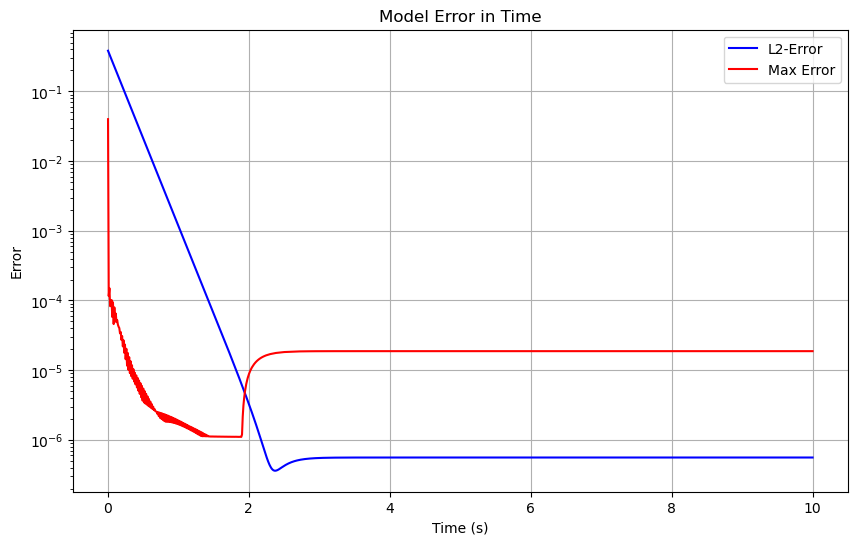

In [225]:
time_values = np.linspace(0, T, num_steps)
plt.figure(figsize =(10 , 6))
plt.plot(time_values,L2_error_list, 'b', label ='L2-Error')
plt.plot(time_values,max_error_list, 'r', label ="Max Error")
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.yscale('log')
#plt.xscale('log')
plt.title('Model Error in Time')
plt.legend()
plt.grid(True)
plt.show()

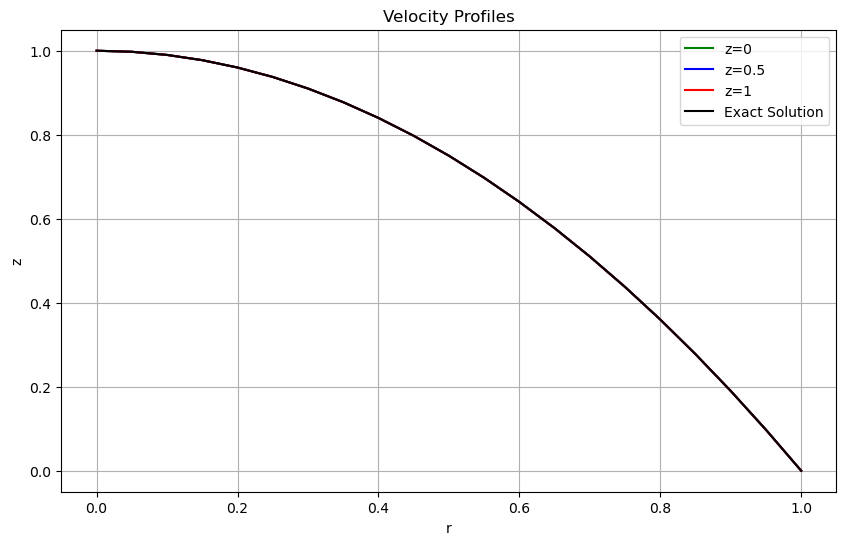

Widget(value='<iframe src="http://localhost:43349/index.html?ui=P_0x7ff64e9b4e10_15&reconnect=auto" class="pyv…

In [226]:
from scipy.interpolate import griddata 

topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

### Velocity Profile Graphing ###
r = geometry[:, 0]
z = geometry[:, 1]
u_r = values[:, 0]  
u_z = values[:, 1]   

grid_resolution = 2*grid_length +1  
ri = np.linspace(0, 1, grid_resolution)
zi = np.linspace(0, 1, grid_resolution)
ri, zi = np.meshgrid(ri, zi)

u_z_interp = griddata((r, z), u_z, (ri, zi), method='cubic')
uprof_in = u_z_interp[0]
uprof_out = u_z_interp[-2]
uprof_mid = u_z_interp[grid_length]
uprof_exact = [1-x**2 for x in np.linspace(0,1, grid_resolution)]
 
plt.figure(figsize =(10 , 6))
plt.plot(np.linspace(0,1, grid_resolution),uprof_in, 'g', label ='z=0')
plt.plot(np.linspace(0,1, grid_resolution),uprof_mid, 'b', label ="z=0.5")
plt.plot(np.linspace(0,1, grid_resolution),uprof_out, 'r', label ="z=1")
plt.plot(np.linspace(0,1, grid_resolution),uprof_exact, 'black', label ="Exact Solution")
plt.xlabel('r')
plt.ylabel('z')
plt.title('Velocity Profiles')
plt.legend()
plt.grid(True)
plt.show()
#################################


# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values

glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")


plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("glyphs.png")